# Conditional Logit: Exercise Solutions

**Tutorial Series**: Discrete Choice Econometrics with PanelBox

**Notebook**: 05 - Conditional Logit (Solutions)

**Author**: PanelBox Contributors

**Date**: 2026-02-17

---

This notebook contains complete solutions for all exercises from the Conditional Logit tutorial.

## Setup

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.special import logsumexp

from panelbox.models.discrete.multinomial import ConditionalLogit

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

DATA_DIR = Path("..") / "data"
OUTPUT_DIR = Path("..") / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"
TABLE_DIR = OUTPUT_DIR / "tables"

# Load data and fit base model (needed for exercises)
data = pd.read_csv(DATA_DIR / "transportation_choice.csv")
data['choice_id'] = data['id'].astype(str) + '_' + data['year'].astype(str)

model = ConditionalLogit(
    data=data,
    choice_col='choice_id',
    alt_col='mode',
    chosen_col='choice',
    alt_varying_vars=['cost', 'time', 'reliability', 'comfort']
)
results = model.fit()

alternatives = sorted(data['mode'].unique())
colors = {'car': '#e74c3c', 'bus': '#3498db', 'metro': '#2ecc71', 'bike': '#f39c12'}

print("Setup complete. Base model fitted.")
print(f"Alternatives: {alternatives}")
print(f"Coefficients: {dict(zip(model.alt_varying_vars, results.params))}")

Setup complete. Base model fitted.
Alternatives: ['bike', 'bus', 'car', 'metro']
Coefficients: {'cost': np.float64(-0.014751866308533798), 'time': np.float64(-0.024669970671884593), 'reliability': np.float64(0.17006766255739783), 'comfort': np.float64(0.3091140021061901)}


---

## Exercise 1: Wide-to-Long Transformation (Easy)

**Task**: Transform a small wide-format dataset into long format suitable for Conditional Logit.

In [2]:
# Exercise 1 Solution

# Step 1: Create wide-format data
np.random.seed(99)
n = 5
modes_ex = ['car', 'bus', 'metro']

wide_data = pd.DataFrame({
    'id': range(1, n + 1),
    'cost_car': np.random.uniform(15, 35, n).round(1),
    'cost_bus': np.random.uniform(3, 6, n).round(1),
    'cost_metro': np.random.uniform(4, 7, n).round(1),
    'time_car': np.random.uniform(20, 45, n).round(0),
    'time_bus': np.random.uniform(40, 80, n).round(0),
    'time_metro': np.random.uniform(25, 50, n).round(0),
    'chosen_mode': np.random.choice(modes_ex, n)
})

print("=== Wide Format ===")
print(wide_data.to_string(index=False))

# Step 2: Transform to long format
long_rows = []
for _, row in wide_data.iterrows():
    for mode in modes_ex:
        long_rows.append({
            'id': int(row['id']),
            'mode': mode,
            'choice': 1 if mode == row['chosen_mode'] else 0,
            'cost': row[f'cost_{mode}'],
            'time': row[f'time_{mode}']
        })

long_data = pd.DataFrame(long_rows)

print("\n=== Long Format ===")
print(long_data.to_string(index=False))

# Step 3: Verify integrity
choice_sums = long_data.groupby('id')['choice'].sum()
assert choice_sums.eq(1).all(), "Integrity check failed!"
print(f"\nIntegrity check PASSED: each ID has exactly one choice=1")
print(f"Wide shape: {wide_data.shape} -> Long shape: {long_data.shape}")
print(f"Expansion factor: {len(modes_ex)}x (one row per alternative)")

=== Wide Format ===
 id  cost_car  cost_bus  cost_metro  time_car  time_bus  time_metro chosen_mode
  1      28.4       4.7         6.3      30.0      48.0        31.0         bus
  2      24.8       3.9         6.2      44.0      62.0        41.0         bus
  3      31.5       3.1         5.1      33.0      52.0        27.0         car
  4      15.6       6.0         5.5      22.0      73.0        35.0       metro
  5      31.2       3.0         6.8      40.0      73.0        27.0         bus

=== Long Format ===
 id  mode  choice  cost  time
  1   car       0  28.4  30.0
  1   bus       1   4.7  48.0
  1 metro       0   6.3  31.0
  2   car       0  24.8  44.0
  2   bus       1   3.9  62.0
  2 metro       0   6.2  41.0
  3   car       1  31.5  33.0
  3   bus       0   3.1  52.0
  3 metro       0   5.1  27.0
  4   car       0  15.6  22.0
  4   bus       0   6.0  73.0
  4 metro       1   5.5  35.0
  5   car       0  31.2  40.0
  5   bus       1   3.0  73.0
  5 metro       0   6.8  27.0

---

## Exercise 2: Elasticity Interpretation (Medium)

**Task**: Calculate own and cross elasticities for a 15% metro fare increase.

In [3]:
# Exercise 2 Solution

# Step 1: Get baseline shares
baseline_probs = results.predict_proba()
baseline_shares = pd.Series(baseline_probs.mean(axis=0), index=alternatives)
print("=== Baseline Choice Shares ===")
print(baseline_shares.round(4))

# Step 2: Simulate 15% metro cost increase
data_metro_up = data.copy()
data_metro_up.loc[data_metro_up['mode'] == 'metro', 'cost'] *= 1.15
data_metro_up['choice_id'] = data_metro_up['id'].astype(str) + '_' + data_metro_up['year'].astype(str)

model_metro = ConditionalLogit(
    data=data_metro_up,
    choice_col='choice_id',
    alt_col='mode',
    chosen_col='choice',
    alt_varying_vars=['cost', 'time', 'reliability', 'comfort']
)

# Predict with original parameters
metro_probs = np.zeros((model_metro.n_choices, model_metro.n_alts))
for i, X in enumerate(model_metro.X_list):
    utilities = X @ results.params
    exp_u = np.exp(utilities - utilities.max())
    metro_probs[i] = exp_u / exp_u.sum()

new_shares = pd.Series(metro_probs.mean(axis=0), index=alternatives)

# Step 3: Compare
comparison = pd.DataFrame({
    'Before': baseline_shares,
    'After (+15% metro cost)': new_shares,
    'Change (pp)': (new_shares - baseline_shares) * 100,
    'Change (%)': ((new_shares - baseline_shares) / baseline_shares) * 100
})

print("\n=== Effect of 15% Metro Cost Increase ===")
print(comparison.round(4))

# Step 4: Verify IIA (proportional substitution)
# Non-metro modes should gain in proportion to their original shares
print("\n=== IIA Verification ===")
non_metro = [m for m in alternatives if m != 'metro']
gains = new_shares[non_metro] - baseline_shares[non_metro]
original_non_metro = baseline_shares[non_metro]
gain_ratios = gains / gains.sum()
original_ratios = original_non_metro / original_non_metro.sum()

print(f"\nGain ratios (actual):              {dict(gain_ratios.round(4))}")
print(f"Original share ratios (expected):   {dict(original_ratios.round(4))}")
print(f"\nIIA implies these should be equal (proportional substitution).")
print(f"Max deviation: {(gain_ratios - original_ratios).abs().max():.6f}")
print(f"-> IIA holds: gains are proportional to original shares.")

=== Baseline Choice Shares ===
bike     0.1195
bus      0.1209
car      0.3250
metro    0.4347
dtype: float64

=== Effect of 15% Metro Cost Increase ===
       Before  After (+15% metro cost)  Change (pp)  Change (%)
bike   0.1195                   0.1201       0.0611      0.5114
bus    0.1209                   0.1215       0.0640      0.5296
car    0.3250                   0.3268       0.1751      0.5389
metro  0.4347                   0.4317      -0.3003     -0.6908

=== IIA Verification ===

Gain ratios (actual):              {'bike': np.float64(0.2035), 'bus': np.float64(0.2132), 'car': np.float64(0.5833)}
Original share ratios (expected):   {'bike': np.float64(0.2114), 'bus': np.float64(0.2138), 'car': np.float64(0.5749)}

IIA implies these should be equal (proportional substitution).
Max deviation: 0.008434
-> IIA holds: gains are proportional to original shares.


---

## Exercise 3: IIA Test with Different Alternatives (Medium)

**Task**: Perform the Hausman-McFadden test by omitting each alternative.

In [4]:
# Exercise 3 Solution

# Full model coefficients
beta_full = results.params[:model.n_alt_varying]
vcov_full = results.vcov[:model.n_alt_varying, :model.n_alt_varying]

print("=== Full Model Coefficients ===")
for i, var in enumerate(model.alt_varying_vars):
    print(f"  {var:12s}: {beta_full[i]:.6f}")

# Estimate restricted models
coef_table = {'Full': dict(zip(model.alt_varying_vars, beta_full))}
hausman_results = []

for mode_remove in alternatives:
    data_r = data[data['mode'] != mode_remove].copy()
    
    # Keep only valid choice occasions
    valid = data_r.groupby('choice_id')['choice'].sum()
    valid_ids = valid[valid == 1].index
    data_r = data_r[data_r['choice_id'].isin(valid_ids)]
    
    model_r = ConditionalLogit(
        data=data_r,
        choice_col='choice_id',
        alt_col='mode',
        chosen_col='choice',
        alt_varying_vars=['cost', 'time', 'reliability', 'comfort']
    )
    results_r = model_r.fit()
    
    beta_r = results_r.params[:model_r.n_alt_varying]
    vcov_r = results_r.vcov[:model_r.n_alt_varying, :model_r.n_alt_varying]
    
    coef_table[f'No {mode_remove}'] = dict(zip(model.alt_varying_vars, beta_r))
    
    # Hausman statistic
    diff = beta_r - beta_full
    vcov_diff = vcov_r - vcov_full
    
    try:
        H = float(diff @ np.linalg.inv(vcov_diff) @ diff)
        df_h = len(diff)
        p_val = 1 - chi2.cdf(abs(H), df_h)
    except np.linalg.LinAlgError:
        H, df_h, p_val = np.nan, len(diff), np.nan
    
    hausman_results.append({
        'Removed': mode_remove,
        'N': model_r.n_choices,
        'H': H,
        'df': df_h,
        'p-value': p_val
    })

# Comparison table
print("\n=== Coefficient Comparison ===")
coef_df = pd.DataFrame(coef_table).round(6)
print(coef_df)

# Hausman test results
print("\n=== Hausman-McFadden Test Results ===")
hausman_df = pd.DataFrame(hausman_results)
print(hausman_df.to_string(index=False))

print("\n=== Discussion ===")
print("The coefficients should be relatively stable across specifications.")
print("Large changes in coefficients when removing an alternative")
print("suggest IIA may be violated for that alternative.")

# Check stability
for var in model.alt_varying_vars:
    full_val = coef_table['Full'][var]
    max_change = max(abs(coef_table[f'No {m}'][var] - full_val) for m in alternatives)
    pct_change = max_change / abs(full_val) * 100
    print(f"  {var:12s}: max change = {pct_change:.1f}%")

=== Full Model Coefficients ===
  cost        : -0.014752
  time        : -0.024670
  reliability : 0.170068
  comfort     : 0.309114

=== Coefficient Comparison ===
               Full  No bike  No bus  No car  No metro
cost        -0.0148  -0.0152 -0.0162  0.0119   -0.0101
time        -0.0247  -0.0265 -0.0236 -0.0249   -0.0189
reliability  0.1701   0.1376  0.1310  0.2259    0.2275
comfort      0.3091   0.3034  0.3329  0.1552    0.3603

=== Hausman-McFadden Test Results ===
Removed    N       H  df    p-value
   bike 3555  9.9226   4 4.1752e-02
    bus 3573 11.1518   4 2.4909e-02
    car 2567 29.2261   4 7.0327e-06
  metro 2305 36.4330   4 2.3570e-07

=== Discussion ===
The coefficients should be relatively stable across specifications.
Large changes in coefficients when removing an alternative
suggest IIA may be violated for that alternative.
  cost        : max change = 180.9%
  time        : max change = 23.2%
  reliability : max change = 33.8%
  comfort     : max change = 49.8%


---

## Exercise 4: Counterfactual — New Mode Introduction (Hard)

**Task**: Simulate introduction of e-scooter as a fifth transport mode.

In [5]:
# Exercise 4 Solution

# Step 1: Define e-scooter attributes
escooter_attrs = {
    'cost': 3.0,         # R$3 per trip
    'time': 25.0,        # 25 minutes average
    'reliability': 3.5,  # Moderate reliability
    'comfort': 2.5       # Low-moderate comfort
}

print("=== E-Scooter Attributes ===")
for attr, val in escooter_attrs.items():
    print(f"  {attr:12s}: {val}")

# Step 2: Predict with 5 alternatives
gamma = results.params  # Estimated coefficients
escooter_z = np.array([escooter_attrs['cost'], escooter_attrs['time'],
                       escooter_attrs['reliability'], escooter_attrs['comfort']])

# Original probabilities (4 modes)
original_probs = results.predict_proba()
original_shares = pd.Series(original_probs.mean(axis=0), index=alternatives)

# New probabilities (5 modes: add e-scooter)
n_choices = model.n_choices
new_probs = np.zeros((n_choices, 5))  # 5 alternatives now

for i, X in enumerate(model.X_list):
    # Original utilities
    utilities_orig = X @ gamma  # 4 utilities
    
    # E-scooter utility (using same coefficients)
    u_escooter = escooter_z @ gamma
    
    # Combined utilities
    utilities_5 = np.append(utilities_orig, u_escooter)
    
    # Compute probabilities with 5 alternatives
    exp_u = np.exp(utilities_5 - utilities_5.max())
    new_probs[i] = exp_u / exp_u.sum()

new_modes = alternatives + ['e-scooter']
new_shares = pd.Series(new_probs.mean(axis=0), index=new_modes)

# Step 3: Compare shares
print("\n=== Choice Shares: Before vs After E-Scooter ===")
comparison_df = pd.DataFrame({
    'Before': pd.Series({m: original_shares.get(m, 0) for m in new_modes}),
    'After': new_shares,
})
comparison_df['Change (pp)'] = (comparison_df['After'] - comparison_df['Before']) * 100
comparison_df['Change (%)'] = np.where(
    comparison_df['Before'] > 0,
    ((comparison_df['After'] - comparison_df['Before']) / comparison_df['Before']) * 100,
    np.nan
)

print(comparison_df.round(4))

# Step 4: Verify IIA proportional substitution
print("\n=== IIA Property Check ===")
print("Under IIA, all existing modes should lose ridership in PROPORTION")
print("to their original shares.")

losses = original_shares - new_shares[alternatives]
loss_ratios = losses / losses.sum()
original_ratios = original_shares / original_shares.sum()

iia_check = pd.DataFrame({
    'Loss ratio': loss_ratios,
    'Original share': original_ratios,
    'Match?': ['Yes' if abs(l - o) < 0.01 else 'No' 
               for l, o in zip(loss_ratios, original_ratios)]
})
print(iia_check.round(4))

print("\n=== Discussion ===")
print(f"E-scooter captures {new_shares['e-scooter']*100:.1f}% of the market.")
print(f"\nUnder IIA, all modes lose proportionally to their original shares.")
print(f"This may be unrealistic: e-scooter is most similar to bike,")
print(f"so we'd expect bike to lose MORE than car or metro.")
print(f"This is a limitation of the Conditional Logit (IIA assumption).")

=== E-Scooter Attributes ===
  cost        : 3.0
  time        : 25.0
  reliability : 3.5
  comfort     : 2.5

=== Choice Shares: Before vs After E-Scooter ===
           Before   After  Change (pp)  Change (%)
bike       0.1195  0.0804      -3.9046    -32.6783
bus        0.1209  0.0791      -4.1703    -34.5075
car        0.3250  0.2081     -11.6881    -35.9636
metro      0.4347  0.2635     -17.1200    -39.3869
e-scooter  0.0000  0.3688      36.8831         NaN

=== IIA Property Check ===
Under IIA, all existing modes should lose ridership in PROPORTION
to their original shares.
       Loss ratio  Original share Match?
bike       0.1059          0.1195     No
bus        0.1131          0.1209    Yes
car        0.3169          0.3250    Yes
metro      0.4642          0.4347     No

=== Discussion ===
E-scooter captures 36.9% of the market.

Under IIA, all modes lose proportionally to their original shares.
This may be unrealistic: e-scooter is most similar to bike,
so we'd expect bike t

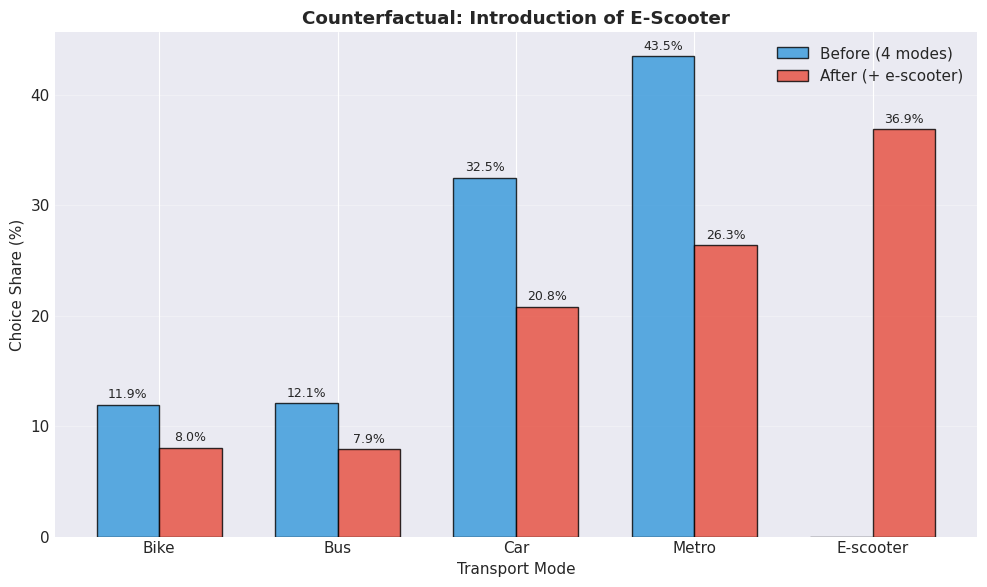

Figure saved to outputs/figures/05_escooter_counterfactual.png


In [6]:
# Visualization for Exercise 4
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(new_modes))
width = 0.35

before_vals = [original_shares.get(m, 0) * 100 for m in new_modes]
after_vals = new_shares.values * 100

bars1 = ax.bar(x - width/2, before_vals, width, label='Before (4 modes)',
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, after_vals, width, label='After (+ e-scooter)',
               color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('Transport Mode')
ax.set_ylabel('Choice Share (%)')
ax.set_title('Counterfactual: Introduction of E-Scooter', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in new_modes])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    h = bar.get_height()
    if h > 0:
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.3, f'{h:.1f}%',
                ha='center', va='bottom', fontsize=9)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.3, f'{h:.1f}%',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / '05_escooter_counterfactual.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to outputs/figures/05_escooter_counterfactual.png")

---

## Key Takeaways from Exercises

1. **Exercise 1**: Wide-to-long transformation is mechanical but critical for Conditional Logit. Each row must represent one (individual $\times$ alternative) pair.

2. **Exercise 2**: Cross elasticities demonstrate the IIA property — when metro cost increases, ALL other modes gain in proportion to their original shares.

3. **Exercise 3**: The Hausman-McFadden test checks coefficient stability when alternatives are removed. Stable coefficients support IIA.

4. **Exercise 4**: Adding a new mode demonstrates both the power and limitation of Conditional Logit. The model predicts market shares for new alternatives, but IIA forces proportional substitution from ALL existing modes, which may be unrealistic for close substitutes.

---

**End of Solutions**